##13.3 입력특성 전처리 


데이터는 일반적으로 모든 특성을 수치특성으로 변환하고 정규화 해야 함 

범주형 특성이나 텍스트 특성이 있다면 숫자로 바꾸어야함 



In [ ]:
# Lamda 층을 사용해 표준화를 수행하는 층을 구현하는 방법 
# 각 특성의 평균을 빼고 표준편차로 나눔

means = np.mean(X_train, axis=0, keepdims=True)
std = np.std(X_train, axis=0, keepdims=True)
eps = keras.backend.epsilon()
model = keras.models.Sequential([
  keras.layers.Lambda(lambda inputs: (inputs-means)/(stds+eps)),
  [...] # 다른층
])

In [ ]:
# means, stds 같은 전역변수보다 완전한 사용자 정의층을 원할수 있음 

class Standardization(keras.layers.Layer):
  def adapt(self, datat_sample):
    self.means_ = np.mean(data_sample, axis=0, leepdims=True)
    self.stds = np.std(data_sample, axis=0, keepdims=True)

  def call(self, inputs):
    return (inputs - self.means) / (self.stds_ + keras.backend.epsilon)

# 모델에 추가하기 전에 데이터 샘플과 함께 adapt()메서드를 호출해야 
# 각 특성에 대해 적절한 평균과 표준편하를 사용할 수 있음 

std_layer = Standardiㅋation()
std_layer.adapt(data_sample)

# 샘플은 충분히 커야하지만 전체 훈련 세트일 필요는 없음 
# 일반적으로 랜덤하게 선택된 수백 개의 샘플이면 충분 (문제마다 다를수는 있음)

In [ ]:
# 일번적인 층처럼 이 전처리 층을 사용할 수 있음 
model = keras.Sequential()
model.add(std_layer)
[...] # 모델구성
model.compile([...])
model.fit([...]

케라스에는 이와같은 전처리 층이 있음 

keras.layers.Normalization 층을 사용가능 

Standardization층과 매우 비슷한게 동작함 




# 13.3.1 원-핫 벡터를 사용해 범주형 특성 인코딩하기 

In [ ]:
# 캘리포니아 주택 데이터셋의 ocean_proximityy 특성 
# look up테이블을 사용해 범주를 인덱스로 매핑

vocab = ["1H OCEAN", "INLAND", "NEAR OCEAN", "NEAR BAY", "ISLAND"]
indices = tf.range(len(vocab), dtype=tf.int64)
table_init = tf.lookup.KeyValueTensorInitializer(vocab, indices)
num_oov_bucktes = 2
table = tf.loopup.StaticVocabularyTable(table_init, num_oov_buckets)


범주개수가 많고 데이터셋이 크거나 범주가 자주 바뀐다면 전체 범주 리스트를 구하는것이 어려울수있음 

샘플데이터를 기반으로 어휘사전을 정의하고 샘플데이터에 없는 다른 범주를 oov버켓이 추가하는것 

실제 oov 버킷이 충분하지 않으면 충돌이 발생할수 있음 


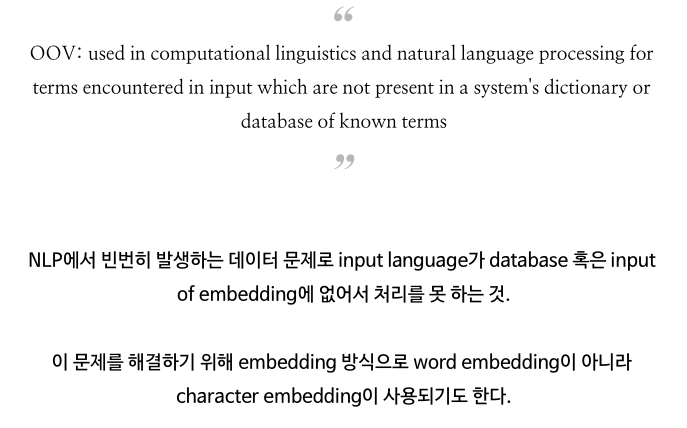

In [ ]:
catetories = tf.constant(["INLAND", "NEAR OCEAN", "NEAR BAY", "ISLAND"])
cat_indices = table.lookup(categoreis)
cat_one_hot = tf.one_hot(cat_indices, depth=len(vocab) +  num_oov_buckets)

NEAR BAY 는 인덱스 3에 매핑되어있고 DESERT 는 두개의 oov 버킷중 하나에 매핑 

tf.one_hot() 함수로 원핫인코딩

캐라스API에 있는 keras.layers.TextVectorization 층이 있음

이 층을 모델시작부분에 추가하고 tf.one_hot()함수가 적용된 Lambda층을 놓으면 인덱슬르 원핫벡터로 바꿀수있음 

어휘사전이 크면 임베딩을 사용하여 인코딩하는 것이 훨씬 효율적
(보통 50개 이상)

# 13.3.2 임베딩을 사용해 범주형 특성 인코딩하기 



임베딩은 범주를 표현하는 훈련 가능한 밀집 벡터 

예를 들어 NEAR BAY 범주는 초기에 [0.131, 0.890]와 같은 랜덤 벡터로 표현되고 NEAR OCEAN 은 [0.631, 0.791]와 같은 또 다른 랜덤 벡터로 표현됨 

표현이 좋을수록 신경망이 정확한 예측을 만들기 쉬움

범주가 유용하게 표현되도록 임베딩이 훈련되는 경향이 있음 

이를 표현학습 이라고함 


**단어 임배딩 **

자연어 처리 작업을 수행할 떄 직접 단어 임베딩을 훈련하는 것보다 사전훈련된 임베딩을 재사용하는것이 나은경우가 있음 

주어진 단어 근처의 단어를 예측하기 위해 신경망을 훈련하여 ㅜ띠어난 성능의 단어 임베딩을 얻을수 있다 

ex) France, Spain, Italy 같이 의미가 관련된 단어들은 함께 군집을 이룸 

단어 임베딩은 어떤 의미가 있는 축을 따라 임베딩 공간안에서 조직됨 

king-nam + Woam = Queen 

물론 성별에 대해 편향된 결과도 있을수 있음 



In [ ]:
#각 범주의 임베딩을 담은 임베딩 행렬을 만들어 랜덤하게 초기화해야함 
#이 행렬은 범주와 ooc 버킷마다 하나의 행이 있고 임베딩 차원마다 하나의 열을 가짐 

embedding_dim = 2 #여기서는 2개의 차원을 사용하지만 일반적으로는 10-300차원을 가짐 
embed_init =  tf.random.uniform([len(voacb) + num_oov_bucket, embedding_dim])
embedding_matrix = tf.Variable(embed_init)



In [ ]:
#이 임베딩을 사용해 앞에서와 동일한 범주 특성을 인코딩 함 

categories = tf.constant(["INLAND", "NEAR OCEAN", "NEAR BAY", "ISLAND"])
cat_indices = table.lookup(categoreis)
tf.nn.embedding_lookup(embedding_martrix, cat_indices)

#tf.nn.embedding_lookup 함수는 임베딩 행렬에서 주어진 인덱스에 해당하는 행을 찾는다 
# 룩업 테이블에서 INLAND 범주의 인덱스가 1이라면 
# tf.nn.embedding_lookup함수가 이 임베딩 행렬에서 두번째 행에있는 임베딩 행렬을 반환함 




케라스는 임베딩 행렬을 처리해주는 keras.layers.Embedding 층을 제공 



In [ ]:
embedding = keras.layers.Embedding(input_dim=len(vocab) + num_oov_buckets, ouput_dim=embedding_dim)
# 범주형 특성을 처리하고 각 범주 마다 임베딩 학습을 하는 케라스 모델 만들수 있음 

regular_inputs = keras.layers.Input(shape=[8])
categories = keras.layers.Input(shape=[], dtype=tf.string)
cat_indices = keras.layers.Lamda(lambda cats:table.lookup(cats))(categories) #람다층을 사용해 범주의 인덱스를 찾은다음
cat_embed = keras.layers.Embedding(input_dim=6, output_dim=2)(cat_indices) #임베딩에서 이 인덱스를 찾음 
encoded_inputs = keras.layers.concatenate([regular_inputs, cat_embed]) #임베딩과 일반 입력을 연결하여 신경망에 주입할 인코드된 입력은 만듦
outputs = keras.layers.Dense(1)(encoded_inputs) 
model = keras.models.Model(inputs=[reqular_inputs, categories], output=[outputs])

keras.layers.TextVectorization 층을 사용할수 있다면 adpat() 메서드를 호출하여 샘플 데이터에서 어휘사전을 추출

그다음 이 층을 모델에 추가하여 인덱스 룩업을 수행할것(람다층을 대신)